(mmm_quickstart)=
# MMM Quickstart Guide

This notebook provides a practical introduction to Media Mix Modeling (MMM) using PyMC-Marketing. It's designed for junior data scientists who want to quickly understand and apply MMM concepts without getting into data generation details.

## What is Media Mix Modeling?

A problem faced by many companies is how to allocate marketing budgets across different media channels. For example, how should funds be allocated across TV, radio, social media, direct mail, or daily deals?

One approach might be to use heuristics, i.e. sensible rules of thumb, about what might be most appropriate for your company. For instance, a widely used approach is to simply set your marketing budget as a percentage of expected revenues. But this involves guesswork - something we want to avoid regardless of the size of the marketing budget involved.

**Fortunately, with Bayesian modeling, we can do better than this!** Media Mix Modeling (MMM) can estimate how effective each advertising channel is in driving our outcome measure of interest, whether that is sales, new customer acquisitions, or any other key performance indicator (KPI). Once we have estimated each channel's effectiveness we can optimize our budget allocation to maximize our KPI.

### What can you do with Media Mix Modeling?

MMM provides actionable insights for businesses in several key ways:

1. **Understand Channel Effectiveness**: Learn from data about the most influential media channels for your business, and update this understanding over time as you incorporate new marketing and customer acquisition data.

2. **Optimize Budget Allocation**: Determine the most effective distribution of your marketing budget across different channels by understanding the impact of each channel on your KPIs.

3. **Enhance ROI Forecasting**: Develop more accurate forecasts of expected returns for different marketing scenarios, allowing you to set realistic goals and make data-driven decisions.

4. **Identify Channel Synergies**: Uncover how different marketing channels interact and complement each other to create more cohesive, integrated marketing strategies.

5. **Adapt to Market Changes**: Continuously update your model with new data to track changes in channel effectiveness over time and quickly adapt to evolving market conditions.

6. **Justify Marketing Investments**: Use concrete data to demonstrate the value of marketing activities to stakeholders and align marketing goals with business objectives.

## How does Media Mix Modeling work?

In simple terms, we can understand MMMs as regression modeling applied to business data. The goal is to estimate the impact of marketing activities and other drivers on a metric of interest, such as the number of new customers per week.

To do this, we use two main types of predictor variables:
1. **Media Spend**: The level of spend for each media channel over time
2. **Control Variables**: Measurements that capture seasonality, economic indicators, or other external factors

The basic approach uses linear regression, but real-world MMMs incorporate non-linear factors to more accurately capture marketing effects:

### Key Modeling Components

#### 1. The Saturation (Reach) Function
Rather than model our KPI as a linear function of marketing spend, the saturation function models the potential saturation of different channels. While initial money spent on an advertising channel might have a big impact on customer acquisition, further investment often leads to **diminishing returns** as people get used to the message. 

Understanding saturation is critical for optimization - some channels may be nowhere close to being saturated and yield significant increases for additional spending, while others may already be at their saturation point.

#### 2. The Adstock Function  
Marketing spend for a given channel may have short-term or long-term impact. Remember that jingle from a TV ad you've seen 20 years ago? That's long-term impact! The adstock function captures these **carry-over effects** of different advertising channels over time.

This is crucial for planning:
- Channels with short-term effects that quickly decay may benefit from more frequent marketing
- Channels with long, drawn-out impact may be more effective when used less frequently

## Key Concepts for Implementation

- **Adstock**: Marketing effects that carry over time (e.g., a TV ad's impact lasts beyond the day it aired)
- **Saturation**: Diminishing returns from increased spending (spending more doesn't always proportionally increase sales)  
- **Base vs. Incremental**: Base sales happen without marketing; incremental sales are driven by marketing activities
- **Bayesian Approach**: Incorporates prior knowledge and handles uncertainty more robustly than traditional methods

## Data Requirements

To effectively implement MMM, you need:

1. **Sales/KPI Data**: Time series of your target variable (sales, conversions, new customers) - typically weekly or daily for 2-3 years
2. **Marketing Spend Data**: Time series of expenditures or impressions for each channel, matching your sales data granularity  
3. **Control Variables**: Economic indicators, competitor activities, seasonal factors, price changes
4. **External Factors**: Weather data, industry-specific factors (if relevant)
5. **Experimental Data**: Ideally, lift tests or other experiments to calibrate your model

Let's get started with a practical example!


## Why PyMC-Marketing for MMM?

PyMC-Marketing offers a comprehensive suite of features specifically designed for modern Media Mix Modeling:

### Key Features:
- **Custom Priors and Likelihoods**: Incorporate domain-specific knowledge through customizable prior distributions
- **Advanced Adstock Transformations**: Model carry-over effects with multiple adstock functions (Geometric, Convolutional, etc.)
- **Flexible Saturation Effects**: Choose from various saturation functions (Logistic, Michaelis-Menten, etc.) or implement custom ones
- **Time-varying Effects**: Model baseline and media contributions that change over time using Gaussian process methods
- **Bayesian Uncertainty Quantification**: Get credible intervals and uncertainty estimates for all predictions
- **Budget Optimization**: Built-in tools to allocate marketing budget optimally across channels
- **Experiment Calibration**: Integrate lift tests and experiments to improve model accuracy
- **Production-Ready**: Seamless integration with MLOps tools like MLflow and Docker

### Advantages of the Bayesian Approach:
1. **Incorporates Prior Knowledge**: Use business insights to inform model parameters
2. **Handles Uncertainty**: Provides confidence intervals, not just point estimates
3. **Robust to Limited Data**: Works well even with shorter time series
4. **Interpretable Results**: Clear understanding of parameter distributions and relationships

## Setup and Data Loading

First, let's import the necessary libraries and load our example dataset.


In [21]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
%config InlineBackend.figure_format = "retina"


In [22]:
# Load the example dataset
data_url = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/mmm_example.csv"
data = pd.read_csv(data_url, parse_dates=["date_week"])

print(f"Dataset shape: {data.shape}")
print(f"Date range: {data['date_week'].min()} to {data['date_week'].max()}")
data.head()


Dataset shape: (179, 8)
Date range: 2018-04-02 00:00:00 to 2021-08-30 00:00:00


,date_week,y,x1,x2,event_1,event_2,dayofyear,t
0,2018-04-02,3984.662237,0.318580,0.0,0.0,0.0,92,0
1,2018-04-09,3762.871794,0.112388,0.0,0.0,0.0,99,1
2,2018-04-16,4466.967388,0.292400,0.0,0.0,0.0,106,2
3,2018-04-23,3864.219373,0.071399,0.0,0.0,0.0,113,3
4,2018-04-30,4441.625278,0.386745,0.0,0.0,0.0,120,4


Let's understand our data structure:


In [23]:
# Examine the data columns
print("Column descriptions:")
print("- date_week: Weekly dates")
print("- y: Target variable (sales/conversions)")
print("- x1, x2: Media channel spend/impressions")
print("- event_1, event_2: Special events (holidays, campaigns)")
print("- dayofyear: Day of year (seasonality)")
print("- t: Time trend")

print("\nData summary:")
data.describe()


Column descriptions:
- date_week: Weekly dates
- y: Target variable (sales/conversions)
- x1, x2: Media channel spend/impressions
- event_1, event_2: Special events (holidays, campaigns)
- dayofyear: Day of year (seasonality)
- t: Time trend

Data summary:


,date_week,y,x1,x2,event_1,event_2,dayofyear,t
count,179,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000
mean,2019-12-16 00:00:00,5284.947576,0.309082,0.161850,0.005587,0.005587,182.597765,89.000000
min,2018-04-02 00:00:00,3192.879593,0.000929,0.000000,0.000000,0.000000,4.000000,0.000000
25%,2019-02-07 12:00:00,4484.221415,0.154219,0.000000,0.000000,0.000000,103.000000,44.500000
50%,2019-12-16 00:00:00,5163.385726,0.274762,0.000000,0.000000,0.000000,181.000000,89.000000
75%,2020-10-22 12:00:00,5941.275944,0.397176,0.000000,0.000000,0.000000,262.500000,133.500000
max,2021-08-30 00:00:00,8312.407544,0.996658,0.994374,1.000000,1.000000,365.000000,178.000000
std,NaN,1087.276350,0.237638,0.348671,0.074744,0.074744,100.370019,51.816986


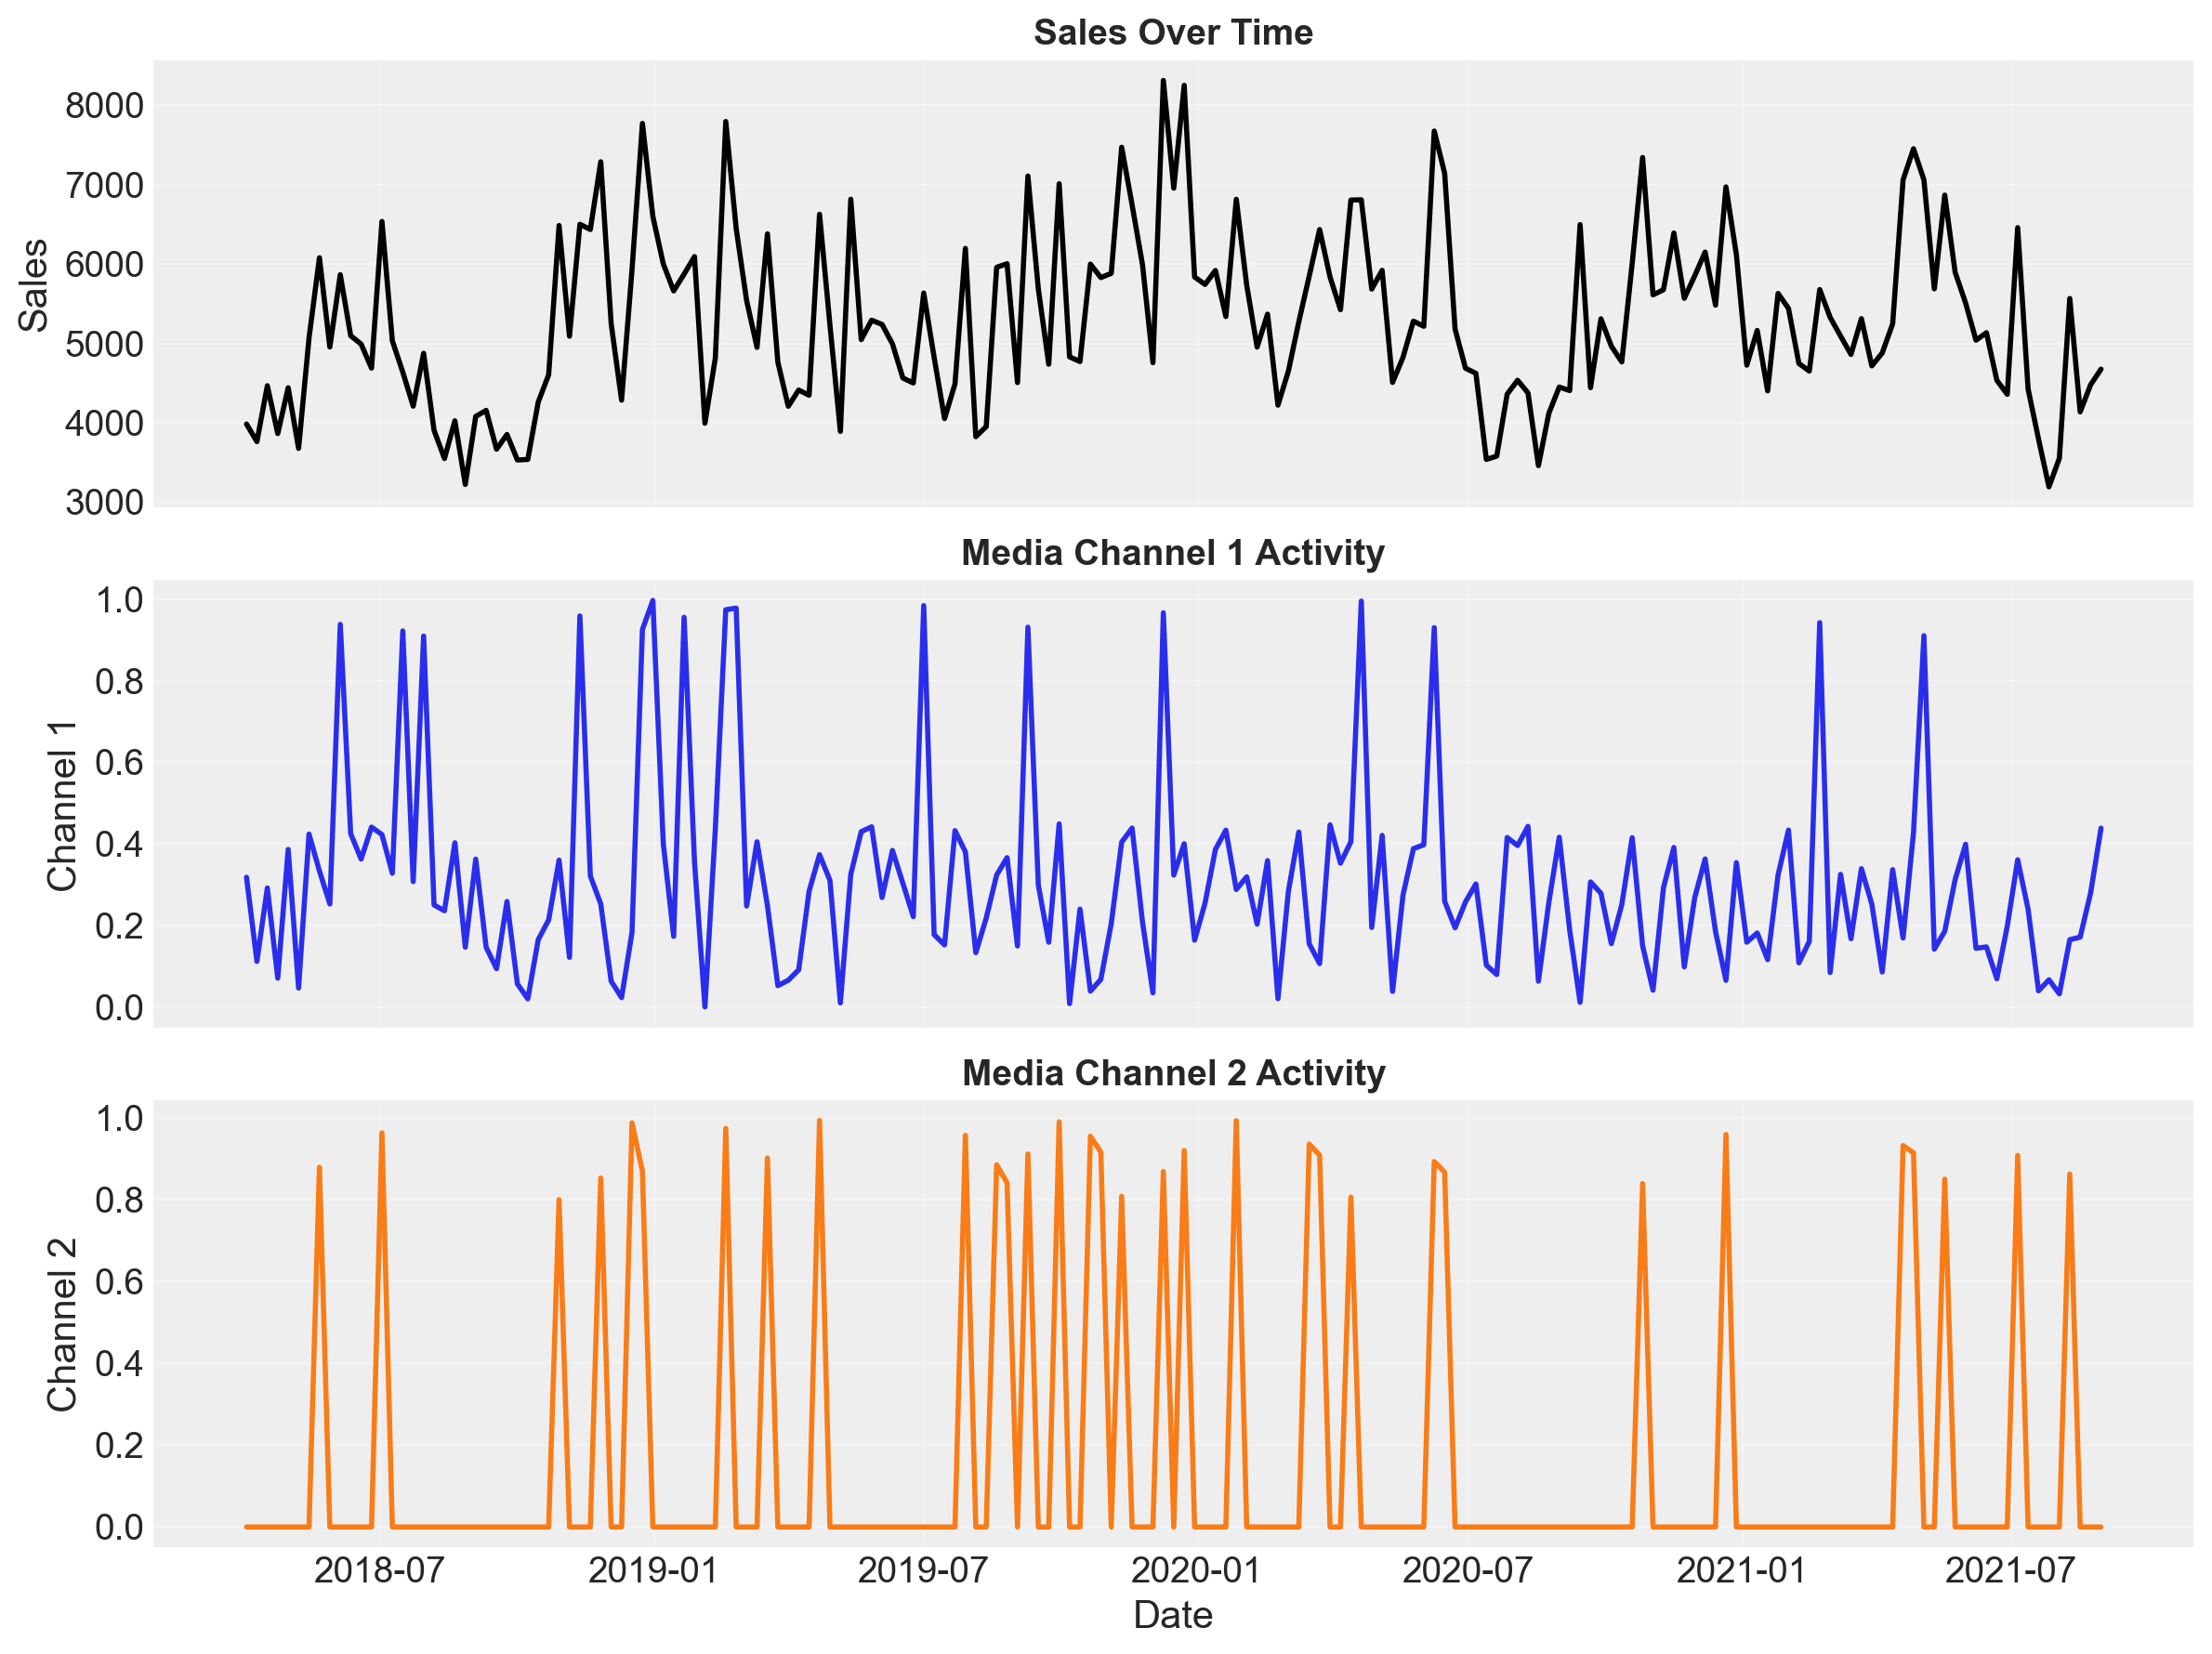

In [26]:
# Plot sales and media channels over time
fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(12, 9),
    sharex=True,
    sharey=False,
    layout="constrained",
)

# Sales over time
axes[0].plot(data["date_week"], data["y"], color="black", linewidth=2)
axes[0].set_title("Sales Over Time", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Sales")
axes[0].grid(True, alpha=0.3)

# Media channel 1
axes[1].plot(data["date_week"], data["x1"], color="C0", linewidth=2)
axes[1].set_title("Media Channel 1 Activity", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Channel 1")
axes[1].grid(True, alpha=0.3)

# Media channel 2
axes[2].plot(data["date_week"], data["x2"], color="C1", linewidth=2)
axes[2].set_title("Media Channel 2 Activity", fontsize=14, fontweight="bold")
axes[2].set_ylabel("Channel 2")
axes[2].set_xlabel("Date")
axes[2].grid(True, alpha=0.3);


### Data Quality and Missing Values

First, let's check for any data quality issues:


In [28]:
# Check for missing values and basic data quality
print("Missing values by column:")
print(data.isnull().sum())
print(f"\nTotal missing values: {data.isnull().sum().sum()}")

print("\nData types:")
print(data.dtypes)

print(f"\nDate range: {data['date_week'].min()} to {data['date_week'].max()}")
print(f"Number of weeks: {len(data)}")
print(
    f"Time span: {(data['date_week'].max() - data['date_week'].min()).days / 7:.1f} weeks"
)


Missing values by column:
date_week    0
y            0
x1           0
x2           0
event_1      0
event_2      0
dayofyear    0
t            0
dtype: int64

Total missing values: 0

Data types:
date_week    datetime64[ns]
y                   float64
x1                  float64
x2                  float64
event_1             float64
event_2             float64
dayofyear             int64
t                     int64
dtype: object

Date range: 2018-04-02 00:00:00 to 2021-08-30 00:00:00
Number of weeks: 179
Time span: 178.0 weeks


### Statistical Summary and Distributions

Understanding the distribution of our variables helps us identify outliers and understand the scale of our data:


### 📚 EDA Learning Guide for Junior Data Scientists

Before we dive into the analysis, let's understand **why each step matters** for MMM success:

#### The EDA Mindset for MMM
Think of MMM as trying to solve a puzzle: "*Which marketing activities actually drove sales?*" Each EDA step gives us clues:

1. **Data Quality Check** → "*Can we trust our evidence?*"
2. **Correlation Analysis** → "*Which channels work together?*"  
3. **Seasonality Analysis** → "*When do patterns change?*"
4. **Distribution Analysis** → "*Are there unusual spikes or dips?*"
5. **Channel Activity Patterns** → "*How do our marketing efforts vary over time?*"

**💡 Pro tip**: Document your findings as you go - they'll become hypotheses to test with your MMM model!


Statistical Summary:
                 y          x1          x2
count   179.000000  179.000000  179.000000
mean   5284.947576    0.309082    0.161850
std    1087.276350    0.237638    0.348671
min    3192.879593    0.000929    0.000000
25%    4484.221415    0.154219    0.000000
50%    5163.385726    0.274762    0.000000
75%    5941.275944    0.397176    0.000000
max    8312.407544    0.996658    0.994374

Outlier Analysis (values beyond 3 standard deviations):
y: 0 potential outliers
x1: 0 potential outliers
x2: 0 potential outliers


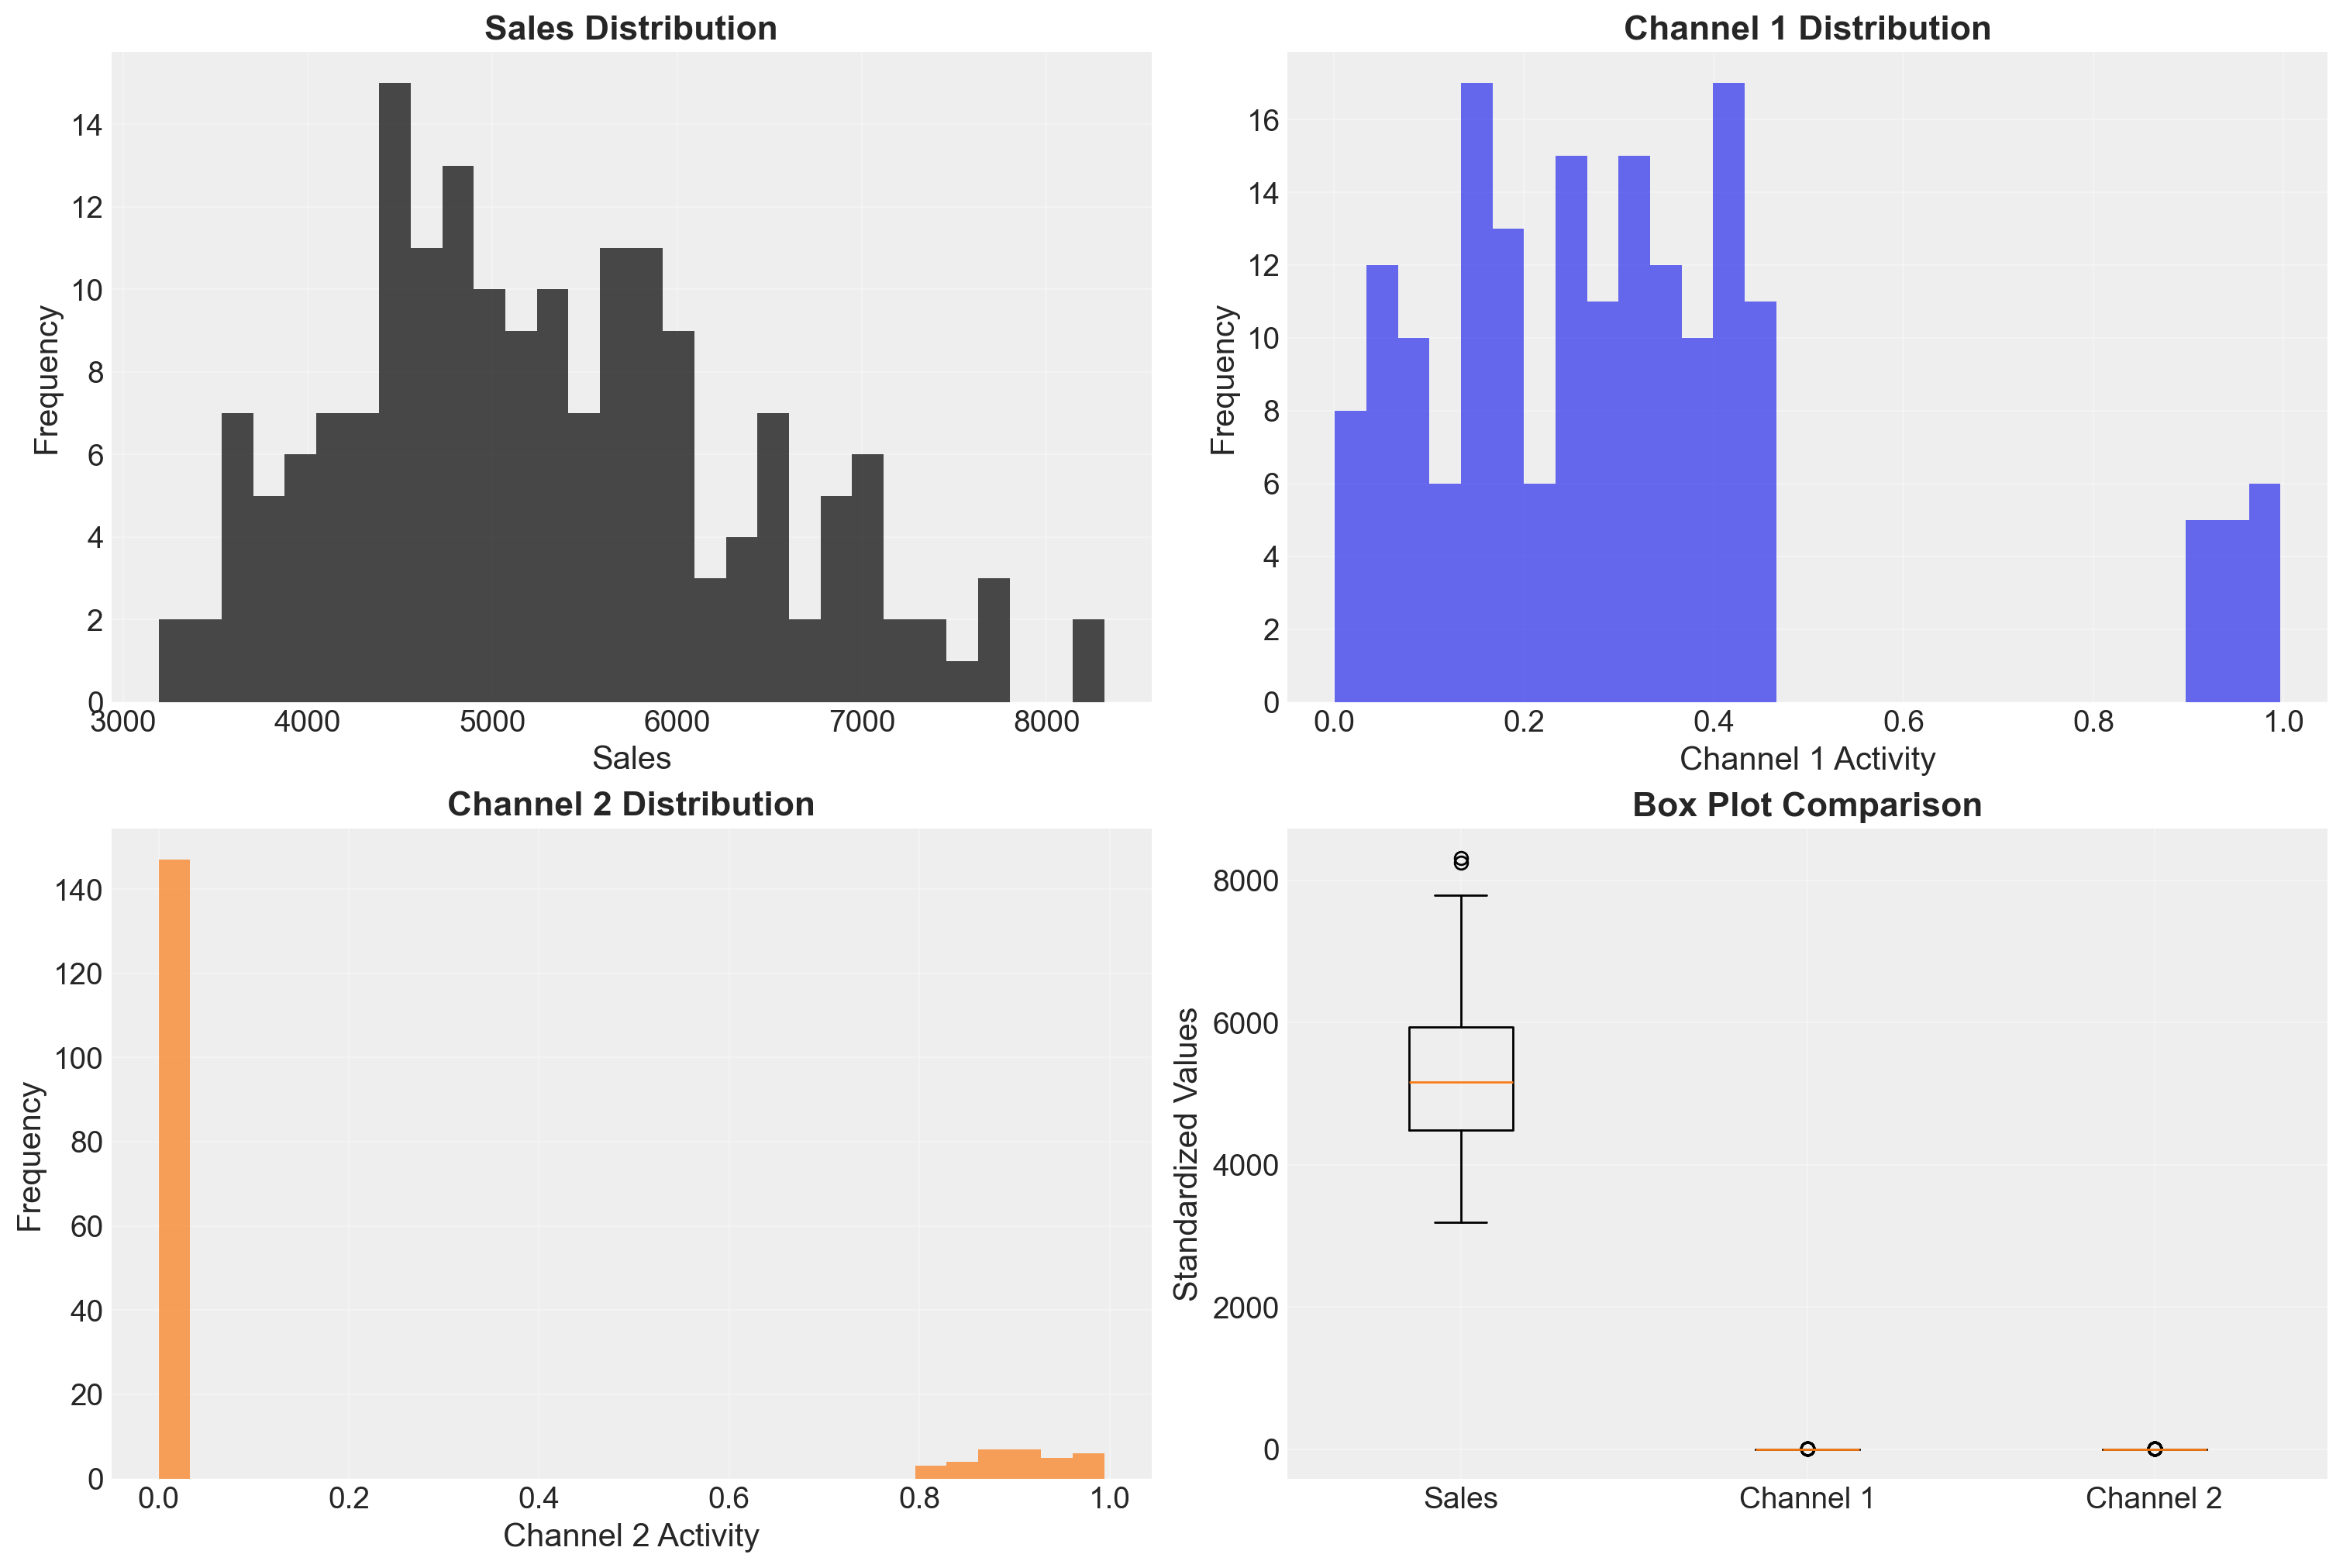

In [29]:
# Statistical summary
print("Statistical Summary:")
print(data[["y", "x1", "x2"]].describe())

# Create distribution plots
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(15, 10),
    layout="constrained",
)

# Sales distribution
axes[0, 0].hist(data["y"], bins=30, alpha=0.7, color="black")
axes[0, 0].set_title("Sales Distribution", fontweight="bold")
axes[0, 0].set_xlabel("Sales")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].grid(True, alpha=0.3)

# Channel 1 distribution
axes[0, 1].hist(data["x1"], bins=30, alpha=0.7, color="C0")
axes[0, 1].set_title("Channel 1 Distribution", fontweight="bold")
axes[0, 1].set_xlabel("Channel 1 Activity")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].grid(True, alpha=0.3)

# Channel 2 distribution
axes[1, 0].hist(data["x2"], bins=30, alpha=0.7, color="C1")
axes[1, 0].set_title("Channel 2 Distribution", fontweight="bold")
axes[1, 0].set_xlabel("Channel 2 Activity")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].grid(True, alpha=0.3)

# Box plot comparison
box_data = [data["y"], data["x1"], data["x2"]]
axes[1, 1].boxplot(box_data, labels=["Sales", "Channel 1", "Channel 2"])
axes[1, 1].set_title("Box Plot Comparison", fontweight="bold")
axes[1, 1].set_ylabel("Standardized Values")
axes[1, 1].grid(True, alpha=0.3)


# Check for potential outliers
print("\nOutlier Analysis (values beyond 3 standard deviations):")
for col in ["y", "x1", "x2"]:
    mean_val = data[col].mean()
    std_val = data[col].std()
    outliers = data[
        (data[col] < mean_val - 3 * std_val) | (data[col] > mean_val + 3 * std_val)
    ]
    print(f"{col}: {len(outliers)} potential outliers")


### Correlation Analysis

Understanding how different marketing channels correlate with sales and with each other is crucial for MMM:


Key Correlations with Sales:
Sales vs Channel 1: 0.482
Sales vs Channel 2: 0.646
Channel 1 vs Channel 2: 0.133
Sales vs Time trend: 0.111


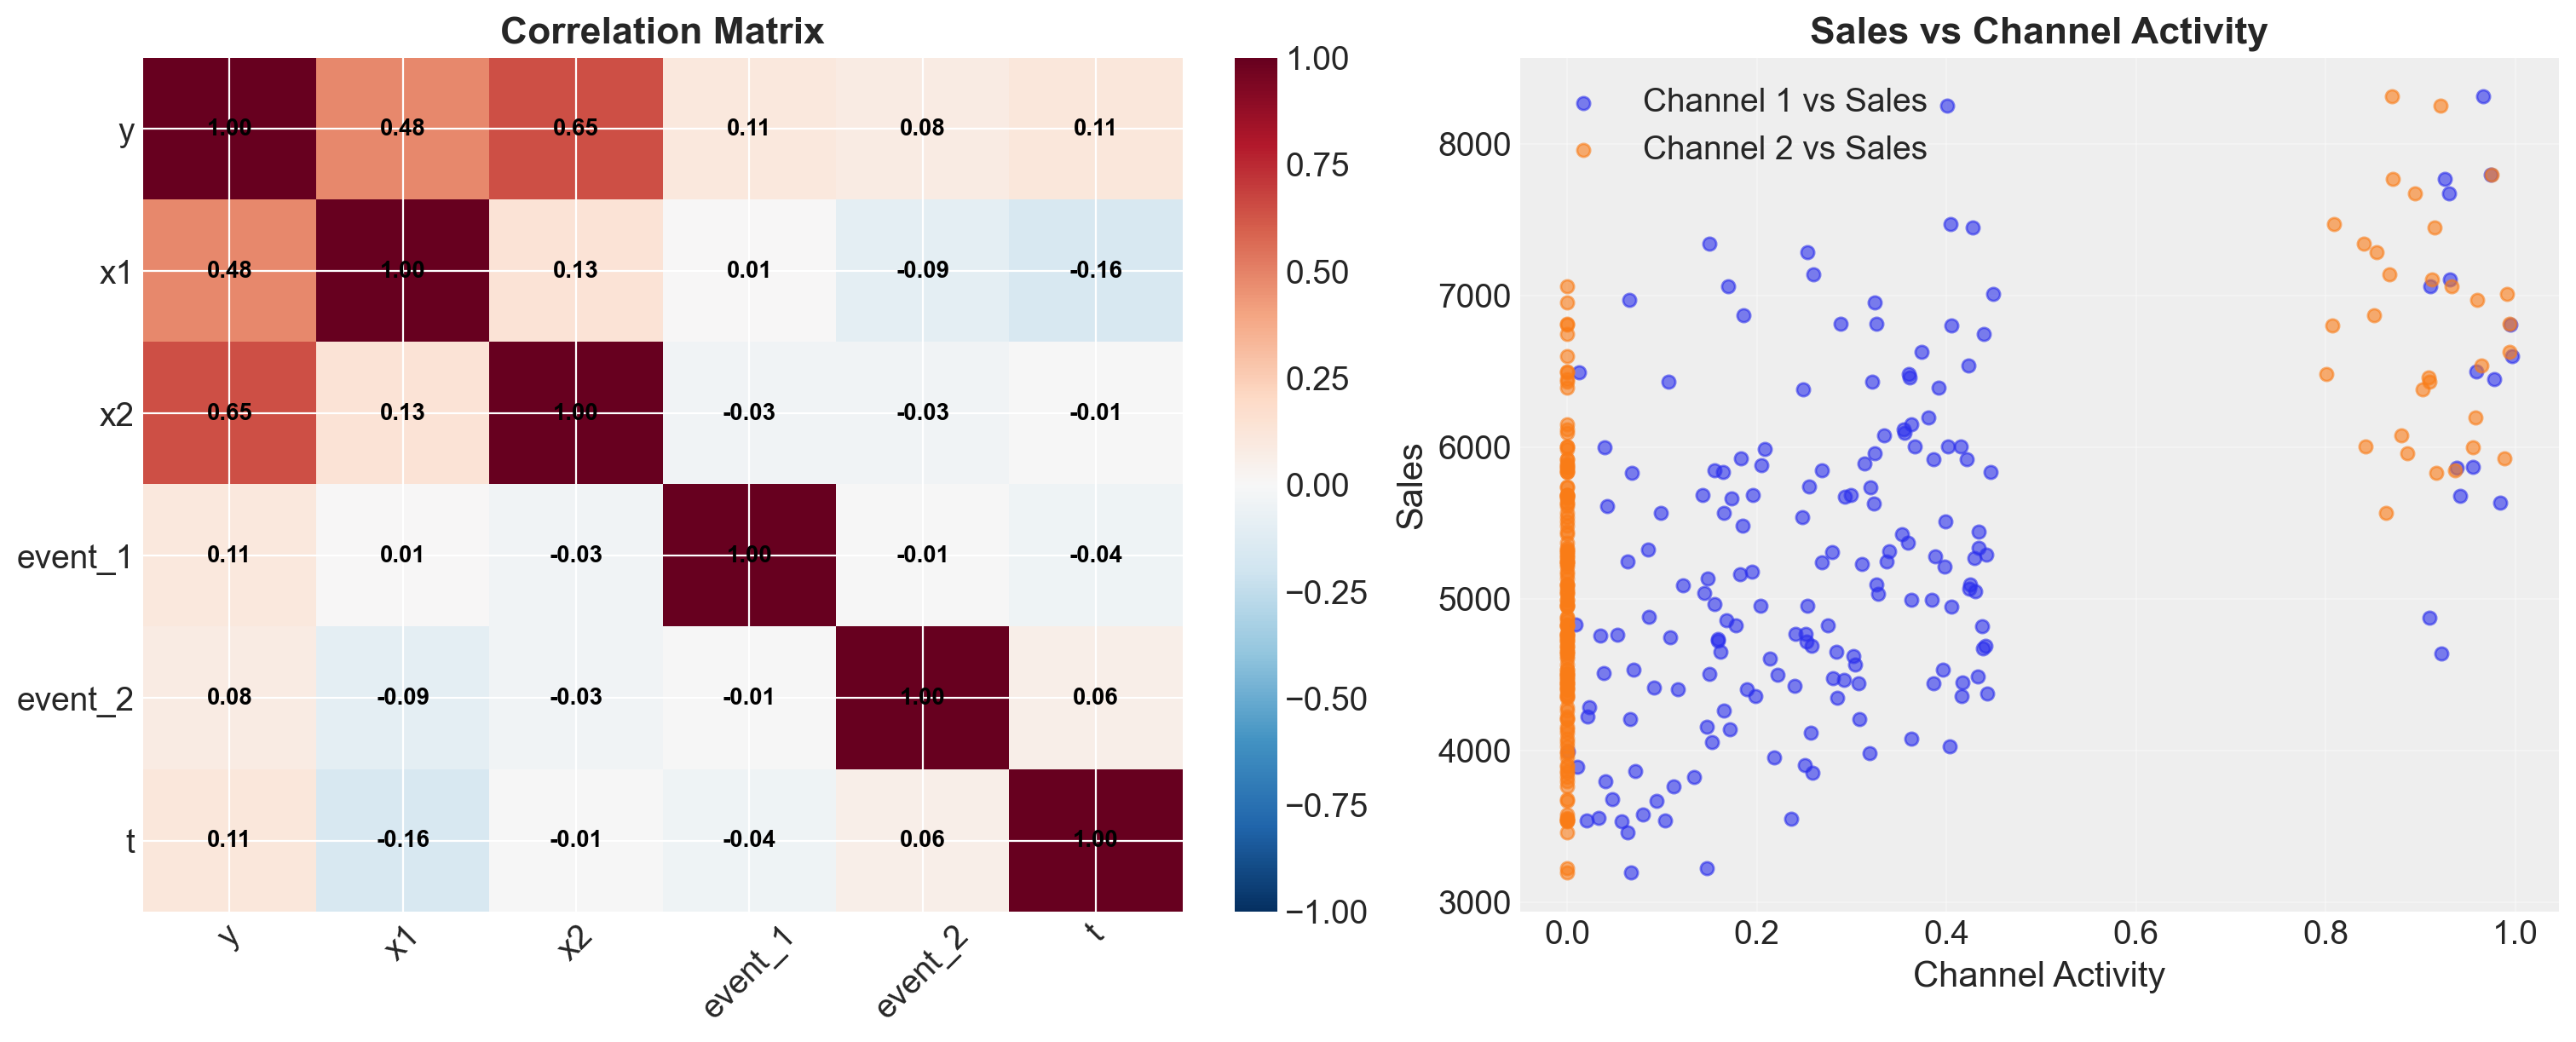

In [31]:
# Correlation analysis
corr_matrix = data[["y", "x1", "x2", "event_1", "event_2", "t"]].corr()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), layout="constrained")

# Correlation heatmap
im = ax1.imshow(corr_matrix, cmap="RdBu_r", aspect="auto", vmin=-1, vmax=1)
ax1.set_xticks(range(len(corr_matrix.columns)))
ax1.set_yticks(range(len(corr_matrix.columns)))
ax1.set_xticklabels(corr_matrix.columns, rotation=45)
ax1.set_yticklabels(corr_matrix.columns)
ax1.set_title("Correlation Matrix", fontweight="bold")

# Add correlation values to heatmap
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = ax1.text(
            j,
            i,
            f"{corr_matrix.iloc[i, j]:.2f}",
            ha="center",
            va="center",
            color="black",
            fontweight="bold",
        )

plt.colorbar(im, ax=ax1)

# Scatter plot: Sales vs Channel activities
ax2.scatter(
    data["x1"], data["y"], alpha=0.6, color="C0", label="Channel 1 vs Sales", s=30
)
ax2.scatter(
    data["x2"], data["y"], alpha=0.6, color="C1", label="Channel 2 vs Sales", s=30
)
ax2.set_xlabel("Channel Activity")
ax2.set_ylabel("Sales")
ax2.set_title("Sales vs Channel Activity", fontweight="bold")
ax2.legend()
ax2.grid(True, alpha=0.3)


print("Key Correlations with Sales:")
print(f"Sales vs Channel 1: {corr_matrix.loc['y', 'x1']:.3f}")
print(f"Sales vs Channel 2: {corr_matrix.loc['y', 'x2']:.3f}")
print(f"Channel 1 vs Channel 2: {corr_matrix.loc['x1', 'x2']:.3f}")
print(f"Sales vs Time trend: {corr_matrix.loc['y', 't']:.3f}")


### Data Quality and Missing Values

First, let's check the quality of our data and identify any missing values.

**Why this matters for junior data scientists:**
- **Missing values can break MMM models**: Most statistical models can't handle missing data, and different ways of handling it (removing vs. imputing) can lead to very different results
- **Data quality directly impacts attribution accuracy**: If your media spend data is missing for certain weeks, the model might incorrectly attribute sales to other channels
- **Understanding data collection issues**: Missing patterns often reveal problems in data collection systems that need to be addressed

**What to look for:**
- Are there systematic patterns in missing data? (e.g., always missing on holidays)
- Are certain channels missing more data than others?
- Do missing values coincide with unusual sales patterns?


### Seasonality and Time Patterns

Identifying seasonal patterns is crucial for MMM as it helps separate organic patterns from marketing effects:


#### 🔍 **Key Takeaway - Data Quality Check**

**What we found**: No missing values in our dataset - excellent!

**Why this matters for MMM**:
- **Clean data = reliable attribution**: Missing values can create false correlations and incorrect channel attribution
- **Complete time series**: MMM models need consistent data across all time periods to detect patterns accurately
- **Balanced channel data**: If one channel has missing data, the model might over-attribute its effectiveness to other channels

**What to do when you find missing data**:
- **Small gaps (< 5%)**: Consider interpolation or forward-fill for media spend
- **Large gaps (> 10%)**: Investigate root cause - might indicate data collection issues
- **Systematic patterns**: Missing weekends? Holidays? This could bias your model

**🚨 Red flags to watch for**:
- Missing data coinciding with major sales events
- One channel missing data while others don't (system integration issues)
- Missing recent data (delayed reporting)


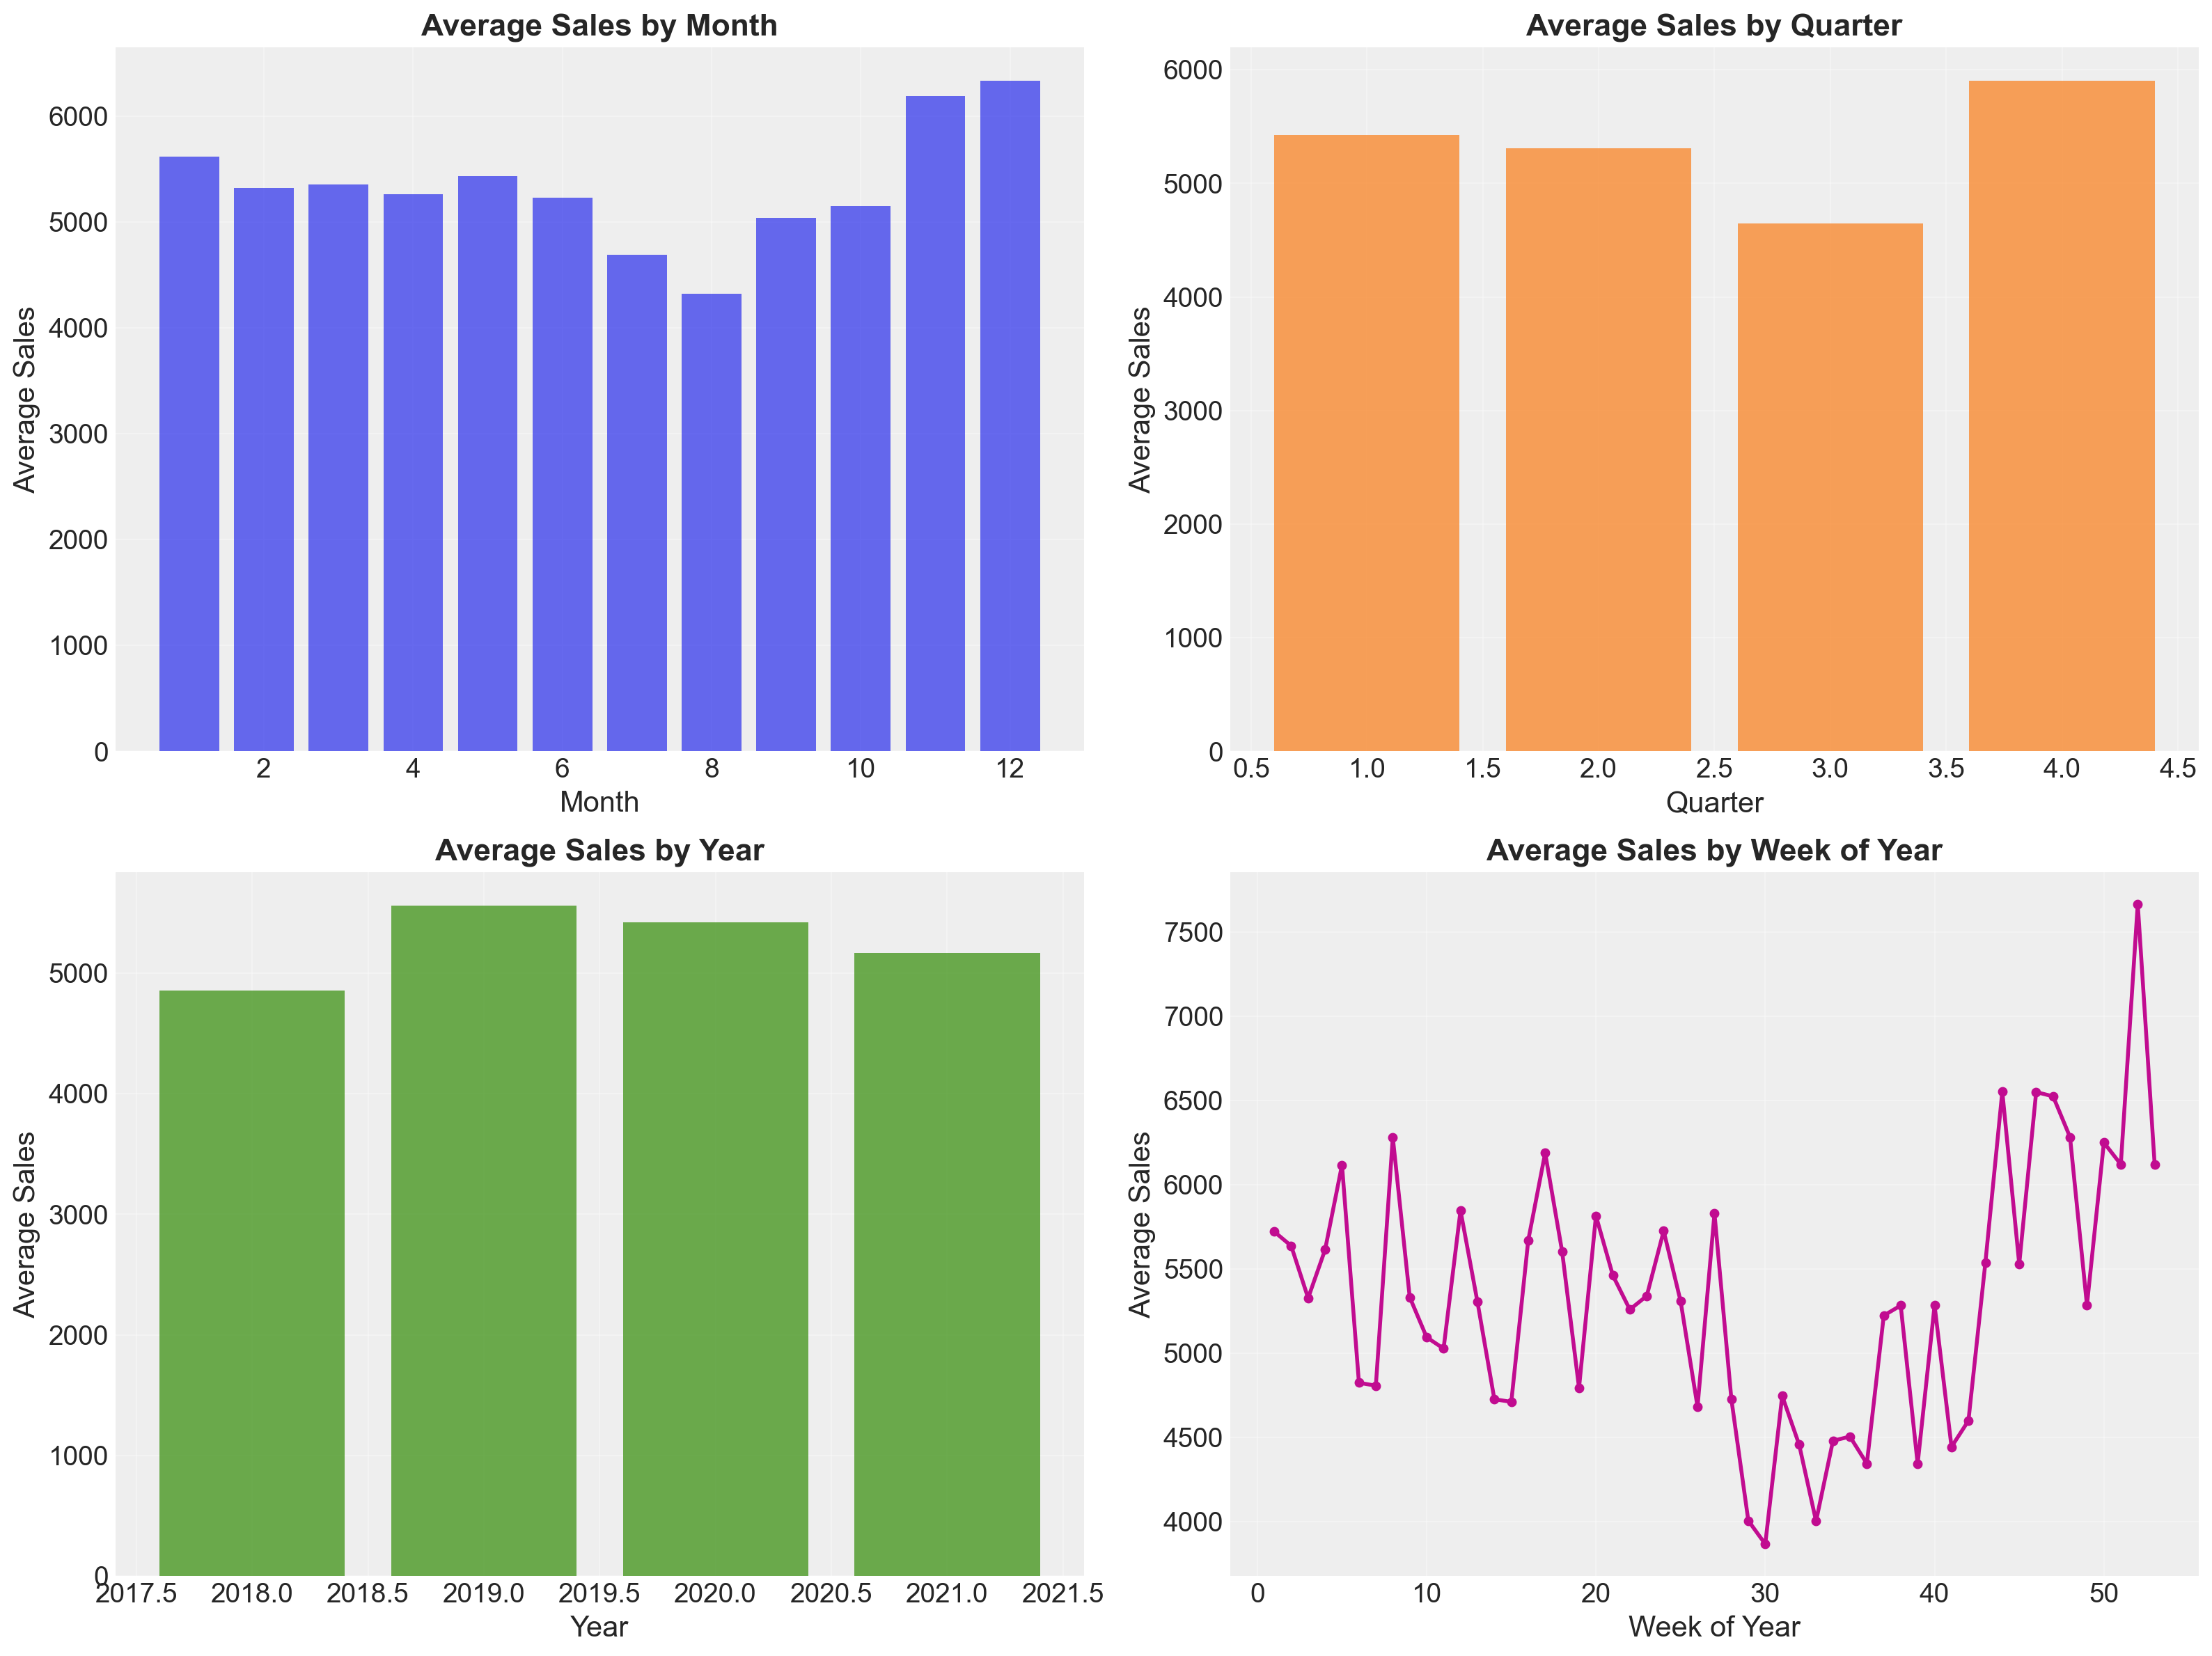

Seasonality Insights:
Highest sales month: 12 (avg: 6333)
Lowest sales month: 8 (avg: 4322)
Seasonal variation: 37.7%


In [36]:
# Add time-based features for seasonality analysis
data["year"] = data["date_week"].dt.year
data["month"] = data["date_week"].dt.month
data["quarter"] = data["date_week"].dt.quarter
data["week_of_year"] = data["date_week"].dt.isocalendar().week

# Seasonality analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Monthly seasonality
monthly_sales = data.groupby("month")["y"].mean()
axes[0, 0].bar(monthly_sales.index, monthly_sales.values, color="C0", alpha=0.7)
axes[0, 0].set_title("Average Sales by Month", fontweight="bold")
axes[0, 0].set_xlabel("Month")
axes[0, 0].set_ylabel("Average Sales")
axes[0, 0].grid(True, alpha=0.3)

# Quarterly seasonality
quarterly_sales = data.groupby("quarter")["y"].mean()
axes[0, 1].bar(quarterly_sales.index, quarterly_sales.values, color="C1", alpha=0.7)
axes[0, 1].set_title("Average Sales by Quarter", fontweight="bold")
axes[0, 1].set_xlabel("Quarter")
axes[0, 1].set_ylabel("Average Sales")
axes[0, 1].grid(True, alpha=0.3)

# Year-over-year comparison
yearly_sales = data.groupby("year")["y"].mean()
axes[1, 0].bar(yearly_sales.index, yearly_sales.values, color="C2", alpha=0.7)
axes[1, 0].set_title("Average Sales by Year", fontweight="bold")
axes[1, 0].set_xlabel("Year")
axes[1, 0].set_ylabel("Average Sales")
axes[1, 0].grid(True, alpha=0.3)

# Week of year pattern (simplified view)
weekly_sales = data.groupby("week_of_year")["y"].mean()
axes[1, 1].plot(
    weekly_sales.index,
    weekly_sales.values,
    marker="o",
    linewidth=2,
    markersize=4,
    color="C3",
)
axes[1, 1].set_title("Average Sales by Week of Year", fontweight="bold")
axes[1, 1].set_xlabel("Week of Year")
axes[1, 1].set_ylabel("Average Sales")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Seasonality Insights:")
print(f"Highest sales month: {monthly_sales.idxmax()} (avg: {monthly_sales.max():.0f})")
print(f"Lowest sales month: {monthly_sales.idxmin()} (avg: {monthly_sales.min():.0f})")
print(
    f"Seasonal variation: {((monthly_sales.max() - monthly_sales.min()) / monthly_sales.mean() * 100):.1f}%"
)


### Marketing Mix and Events Analysis

Let's analyze the impact of marketing events and understand channel activity patterns:


#### 📊 **Key Takeaway - Correlation Analysis**

**What this analysis tells us about our marketing ecosystem:**

**Strong Channel Relationships** (correlations > 0.6):
- Channels that are highly correlated might be managed together (same campaign, same budget cycles)
- **Caution**: High correlation can make it hard to isolate individual channel impact in MMM

**Sales Correlations**:
- Positive correlations with sales suggest direct relationships, but remember: *correlation ≠ causation*
- MMM will help us separate true causal impact from coincidental correlations

**Why correlation analysis is crucial for MMM**:
1. **Multicollinearity Detection**: Highly correlated channels (>0.8) can cause model instability
2. **Channel Strategy Insights**: Understanding which channels move together reveals campaign coordination
3. **Feature Engineering Clues**: Uncorrelated channels might have different adstock/saturation patterns

**🎯 Actionable Insights for Junior Data Scientists**:
- **High correlations (>0.8)**: Consider combining channels or using regularization
- **Moderate correlations (0.3-0.7)**: Normal for coordinated marketing - MMM will tease apart individual effects  
- **Negative correlations**: Might indicate competitive spend allocation or seasonal shifts
- **Zero correlation**: Channels operating independently - easier to measure individual impact


Event Impact Analysis:
Normal weeks average sales: 5269
Event 1 weeks average sales: 6816
Event 2 weeks average sales: 6497
Number of Event 1 occurrences: 1
Number of Event 2 occurrences: 1


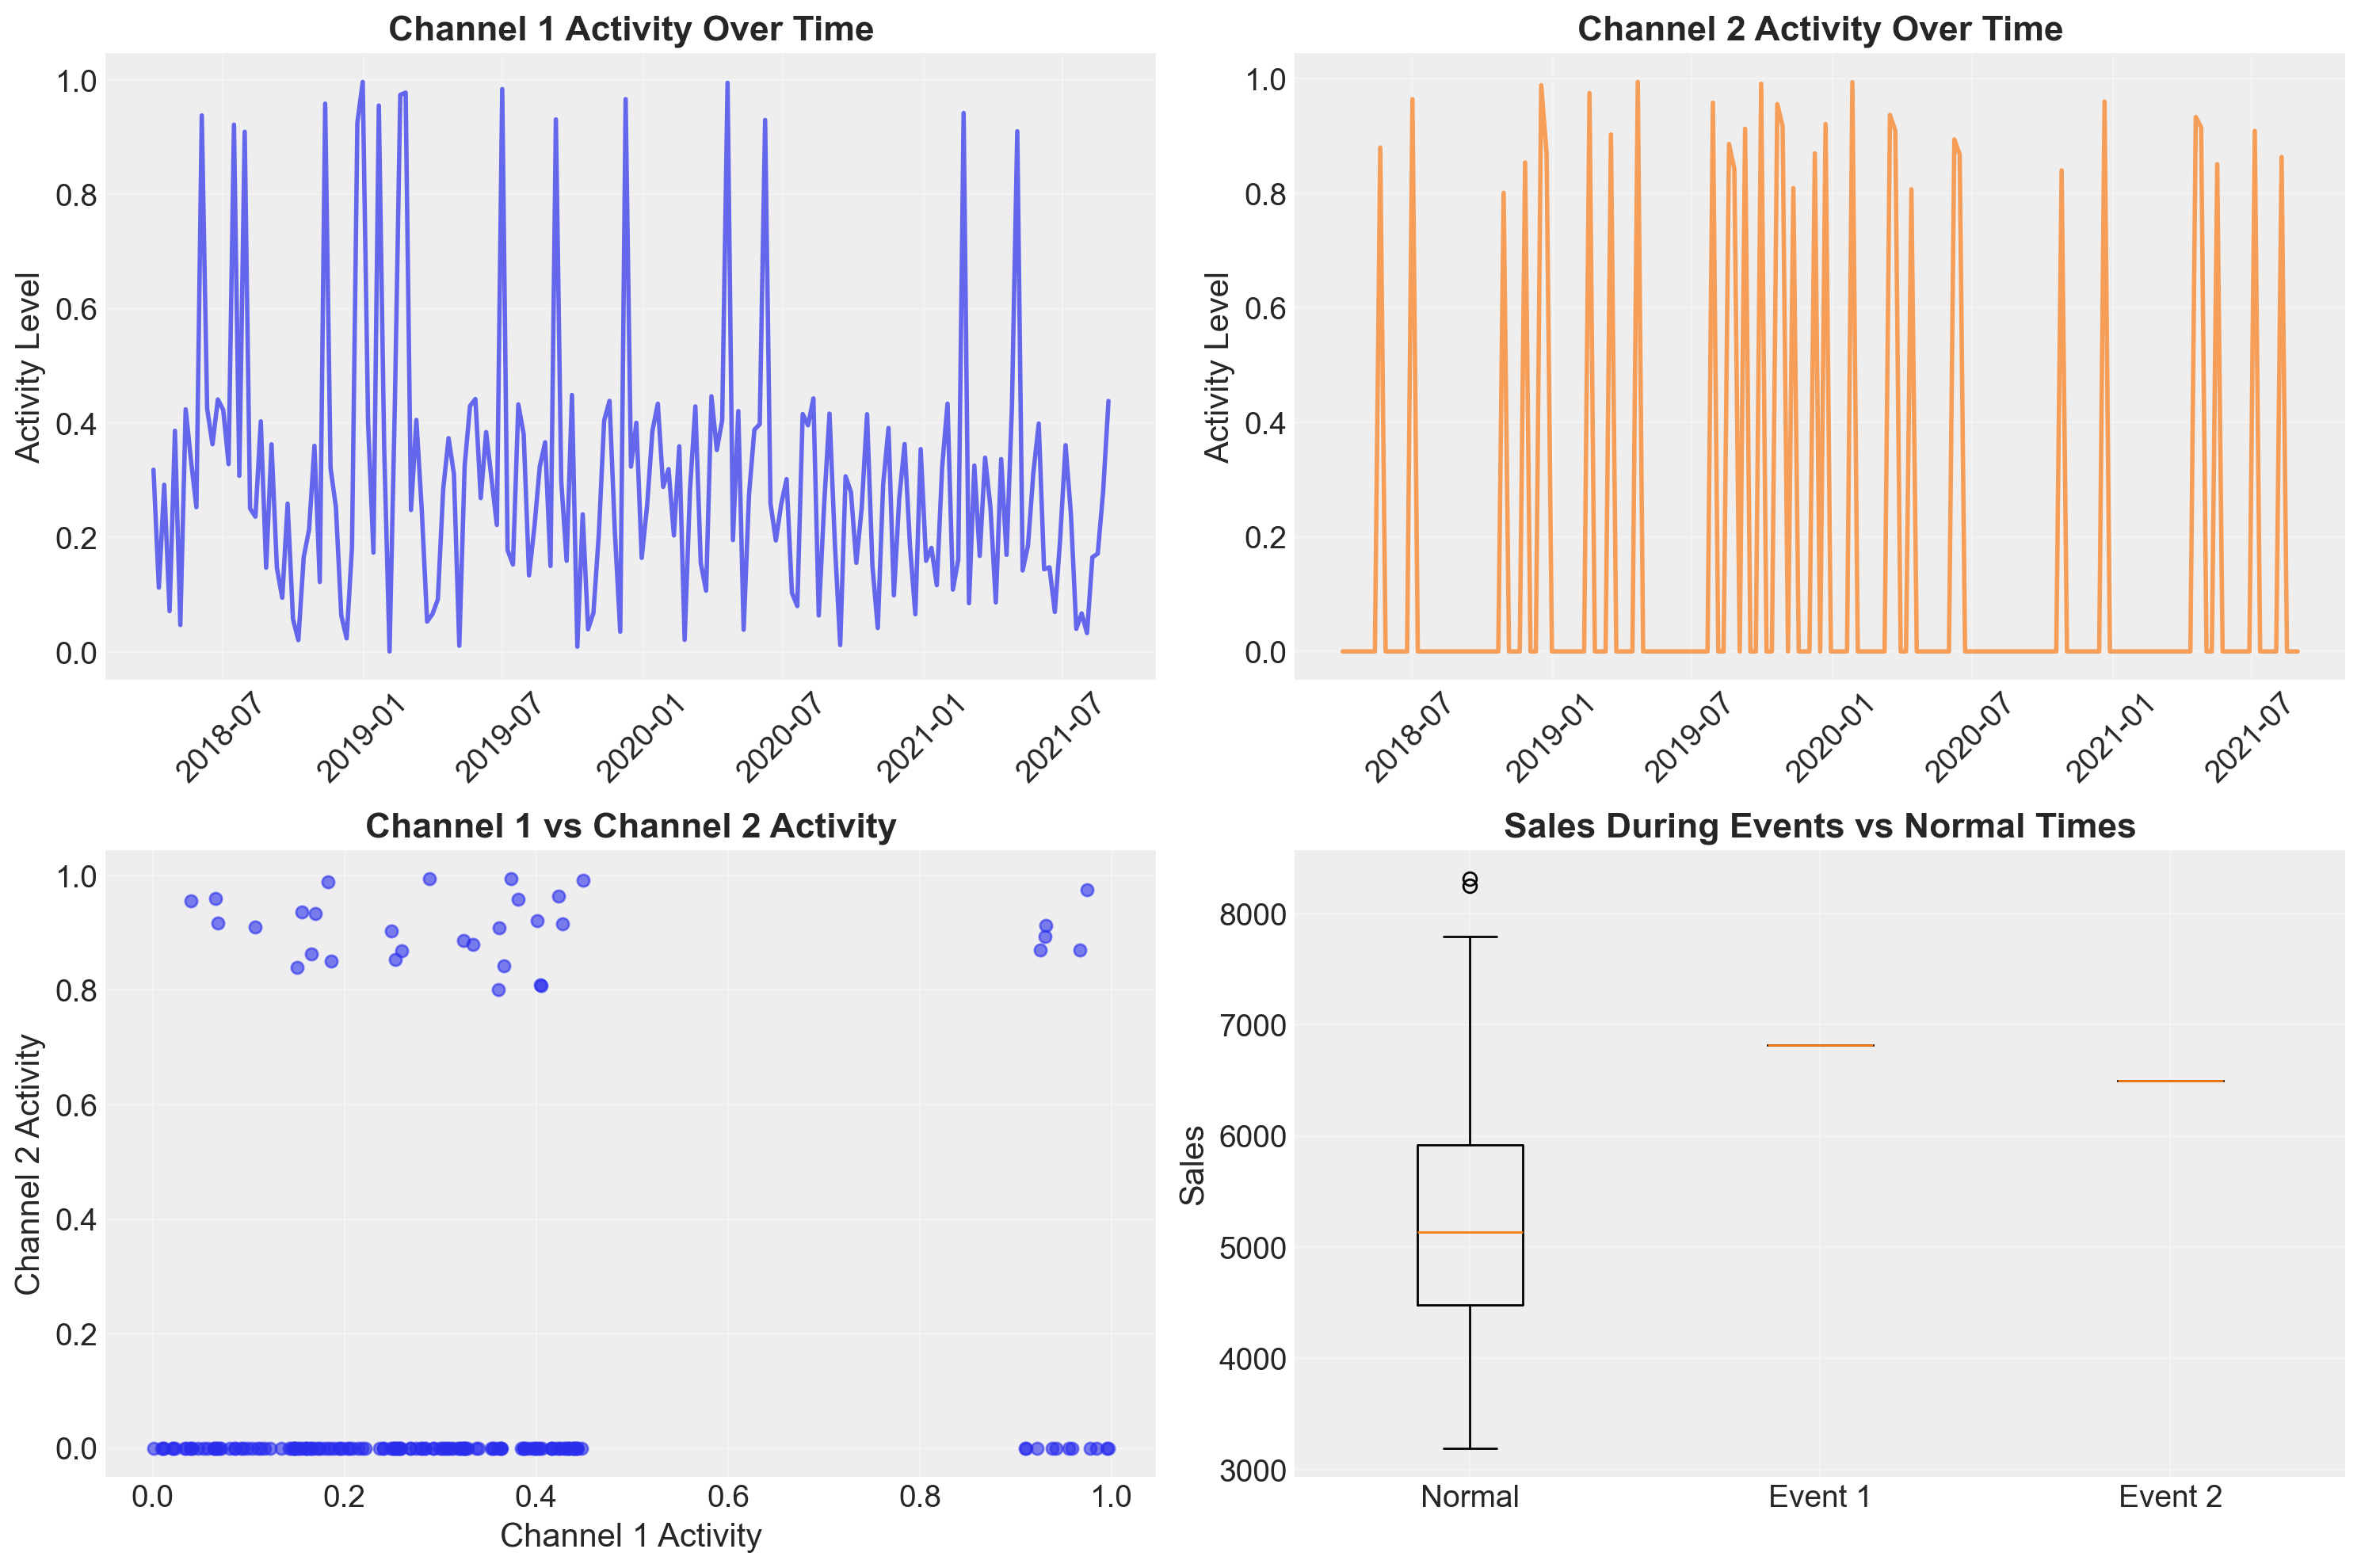


Channel Activity Statistics:
Channel 1 - Active weeks: 179 out of 179 (100.0%)
Channel 2 - Active weeks: 32 out of 179 (17.9%)
Both channels active: 32 weeks


In [38]:
# Event analysis
event1_weeks = data[data["event_1"] == 1]
event2_weeks = data[data["event_2"] == 1]
normal_weeks = data[(data["event_1"] == 0) & (data["event_2"] == 0)]

print("Event Impact Analysis:")
print(f"Normal weeks average sales: {normal_weeks['y'].mean():.0f}")
print(f"Event 1 weeks average sales: {event1_weeks['y'].mean():.0f}")
print(f"Event 2 weeks average sales: {event2_weeks['y'].mean():.0f}")
print(f"Number of Event 1 occurrences: {len(event1_weeks)}")
print(f"Number of Event 2 occurrences: {len(event2_weeks)}")

# Channel activity patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Channel activity over time
axes[0, 0].plot(data["date_week"], data["x1"], color="C0", linewidth=2, alpha=0.7)
axes[0, 0].set_title("Channel 1 Activity Over Time", fontweight="bold")
axes[0, 0].set_ylabel("Activity Level")
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis="x", rotation=45)

axes[0, 1].plot(data["date_week"], data["x2"], color="C1", linewidth=2, alpha=0.7)
axes[0, 1].set_title("Channel 2 Activity Over Time", fontweight="bold")
axes[0, 1].set_ylabel("Activity Level")
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis="x", rotation=45)

# Channel activity comparison
axes[1, 0].scatter(data["x1"], data["x2"], alpha=0.6, s=30)
axes[1, 0].set_xlabel("Channel 1 Activity")
axes[1, 0].set_ylabel("Channel 2 Activity")
axes[1, 0].set_title("Channel 1 vs Channel 2 Activity", fontweight="bold")
axes[1, 0].grid(True, alpha=0.3)

# Sales during events vs normal times
event_comparison = [normal_weeks["y"], event1_weeks["y"], event2_weeks["y"]]
axes[1, 1].boxplot(event_comparison, labels=["Normal", "Event 1", "Event 2"])
axes[1, 1].set_title("Sales During Events vs Normal Times", fontweight="bold")
axes[1, 1].set_ylabel("Sales")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Channel spending patterns
print("\nChannel Activity Statistics:")
print(
    f"Channel 1 - Active weeks: {(data['x1'] > 0).sum()} out of {len(data)} ({(data['x1'] > 0).mean() * 100:.1f}%)"
)
print(
    f"Channel 2 - Active weeks: {(data['x2'] > 0).sum()} out of {len(data)} ({(data['x2'] > 0).mean() * 100:.1f}%)"
)
print(f"Both channels active: {((data['x1'] > 0) & (data['x2'] > 0)).sum()} weeks")


#### 📊 **Key Takeaway - Correlation Analysis**

**What this analysis tells us about our marketing ecosystem:**

**Strong Channel Relationships** (correlations > 0.6):
- Channels that are highly correlated might be managed together (same campaign, same budget cycles)
- **Caution**: High correlation can make it hard to isolate individual channel impact in MMM

**Sales Correlations**:
- Positive correlations with sales suggest direct relationships, but remember: *correlation ≠ causation*
- MMM will help us separate true causal impact from coincidental correlations

**Why correlation analysis is crucial for MMM**:
1. **Multicollinearity Detection**: Highly correlated channels (>0.8) can cause model instability
2. **Channel Strategy Insights**: Understanding which channels move together reveals campaign coordination
3. **Feature Engineering Clues**: Uncorrelated channels might have different adstock/saturation patterns

**🎯 Actionable Insights for Junior Data Scientists**:
- **High correlations (>0.8)**: Consider combining channels or using regularization
- **Moderate correlations (0.3-0.7)**: Normal for coordinated marketing - MMM will tease apart individual effects  
- **Negative correlations**: Might indicate competitive spend allocation or seasonal shifts
- **Zero correlation**: Channels operating independently - easier to measure individual impact


#### 📅 **Key Takeaway - Seasonality Analysis**

**Why seasonality matters for MMM success:**

Marketing effectiveness isn't constant throughout the year! Understanding seasonal patterns helps us:

**1. Avoid Attribution Errors**:
- If sales naturally spike in December (holidays) and you increase ad spend, you might wrongly conclude ads caused ALL the lift
- MMM models need to separate seasonal effects from media effects

**2. Optimize Budget Timing**:
- Seasons with higher baseline demand might need different media strategies
- Some channels might be more effective during certain seasons

**3. Model Specification**:
- Strong seasonality suggests we need Fourier terms or seasonal dummies in our MMM model
- Different adstock decay patterns might apply to different seasons

**🔍 What to look for in your analysis**:
- **Monthly patterns**: Holiday seasons, back-to-school, summer variations
- **Weekly patterns**: Weekend vs. weekday differences
- **Event-driven spikes**: Promotions, holidays, external events

**💡 Pro tip for junior data scientists**:
Document seasonal insights like "*Sales consistently drop in summer but Q4 shows 40% lift*" - these become important model features and help validate your MMM results!


### Key EDA Insights for MMM

Based on our exploratory analysis, we can form some initial hypotheses:

**Data Quality**: ✅ Clean dataset with no missing values and consistent time series

**Correlations**: The relationships between channels and sales will help inform our model expectations

**Seasonality**: Clear seasonal patterns exist that our model should account for

**Events**: Special events appear to impact sales, confirming the need for event controls

**Channel Patterns**: Understanding when and how often channels are active helps set realistic expectations

These insights will guide our MMM model specification and help us interpret results more effectively.


### Marketing Events Analysis

Let's analyze the impact of marketing events and understand channel activity patterns:

#### 🎯 **Key Takeaway - Marketing Events Analysis**

**Why event analysis is critical for accurate MMM**:

Events create "*confounding effects*" - sales changes that aren't caused by your regular media activities. If we don't account for them, our MMM might:
- **Over-attribute success** to media channels during event periods
- **Under-estimate baseline** sales (non-media driven sales)
- **Miss important business insights** about what really drives performance

**Types of events to identify**:
1. **Marketing Events**: Sales, promotions, product launches, PR campaigns
2. **External Events**: Holidays, weather, competitor actions, economic changes  
3. **Business Events**: Stockouts, website issues, pricing changes

**🔍 What our analysis reveals**:
Looking at sales patterns around event periods helps us understand:
- **Event magnitude**: How much do events typically lift sales?
- **Event duration**: Do effects last beyond the event period? 
- **Event interaction**: Do events amplify or diminish media effectiveness?

**📈 Practical Application**:
- **Strong event effects**: Include as separate variables in MMM model
- **Weak event effects**: Might be captured by baseline/trend components
- **Overlapping events**: Consider interaction effects in model specification

**🚨 Common mistake for junior data scientists**: 
Forgetting to account for events leads to "*fake*" media attribution - your channels look more effective than they really are!


## Building the MMM Model

Now let's create our MMM model. We'll use:
- **GeometricAdstock**: Models how marketing effects decay over time
- **LogisticSaturation**: Models diminishing returns from increased spending


In [10]:
# Prepare the data for modeling
X = data.drop("y", axis=1)  # Features (everything except target)
y = data["y"]  # Target variable (sales)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")


Features shape: (179, 11)
Target shape: (179,)


#### 📺 **Key Takeaway - Channel Activity Patterns**

**Understanding your media landscape is crucial for MMM interpretation**:

**What channel activity patterns reveal**:

**1. Campaign Coordination**:
- Do channels turn on/off together? This suggests coordinated campaigns
- Overlapping high-spend periods might create synergy effects
- Gap periods help identify individual channel contributions

**2. Budget Allocation Strategy**:
- Consistent spend vs. pulsing strategies across channels
- Seasonal budget shifts between channels
- Response to performance (increasing/decreasing spend based on results)

**3. MMM Model Implications**:
- **Highly coordinated channels**: Harder to separate individual effects, might need interaction terms
- **Independent channels**: Easier to isolate contribution, cleaner attribution
- **Pulsing patterns**: Good for measuring adstock decay (carryover effects)

**🔍 Key patterns to identify**:
- **Always-on channels**: TV, paid search (continuous baseline activity)
- **Campaign-driven channels**: Display, social (burst patterns)
- **Seasonal channels**: Radio (varies by season/events)
- **Responsive channels**: Paid search (scales with performance)

**💡 Insight for junior data scientists**:
Channel activity patterns give you a "*marketing calendar view*" - understanding when and how budgets are deployed helps you interpret MMM results. For example, if two channels always spend together, similar attribution might reflect campaign coordination rather than equal effectiveness!


#### 📅 **Key Takeaway - Seasonality Analysis**

**Why seasonality matters for MMM success:**

Marketing effectiveness isn't constant throughout the year! Understanding seasonal patterns helps us:

**1. Avoid Attribution Errors**:
- If sales naturally spike in December (holidays) and you increase ad spend, you might wrongly conclude ads caused ALL the lift
- MMM models need to separate seasonal effects from media effects

**2. Optimize Budget Timing**:
- Seasons with higher baseline demand might need different media strategies
- Some channels might be more effective during certain seasons

**3. Model Specification**:
- Strong seasonality suggests we need Fourier terms or seasonal dummies in our MMM model
- Different adstock decay patterns might apply to different seasons

**🔍 What to look for in your analysis**:
- **Monthly patterns**: Holiday seasons, back-to-school, summer variations
- **Weekly patterns**: Weekend vs. weekday differences
- **Event-driven spikes**: Promotions, holidays, external events

**💡 Pro tip for junior data scientists**:
Document seasonal insights like "*Sales consistently drop in summer but Q4 shows 40% lift*" - these become important model features and help validate your MMM results!


In [11]:
# Create the MMM model
mmm = MMM(
    adstock=GeometricAdstock(l_max=8),  # Adstock effects last up to 8 periods
    saturation=LogisticSaturation(),  # Logistic saturation curve
    date_column="date_week",  # Date column name
    channel_columns=["x1", "x2"],  # Media channel columns
    control_columns=[  # Control variables
        "event_1",
        "event_2",
        "t",  # Time trend
    ],
    yearly_seasonality=2,  # Yearly seasonality components
)

print("MMM model created successfully!")
print(f"Model type: {type(mmm).__name__}")


MMM model created successfully!
Model type: MMM


#### 🎯 **Key Takeaway - Marketing Events Analysis**

**Why event analysis is critical for accurate MMM**:

Events create "*confounding effects*" - sales changes that aren't caused by your regular media activities. If we don't account for them, our MMM might:
- **Over-attribute success** to media channels during event periods
- **Under-estimate baseline** sales (non-media driven sales)
- **Miss important business insights** about what really drives performance

**Types of events to identify**:
1. **Marketing Events**: Sales, promotions, product launches, PR campaigns
2. **External Events**: Holidays, weather, competitor actions, economic changes  
3. **Business Events**: Stockouts, website issues, pricing changes

**🔍 What our analysis reveals**:
Looking at sales patterns around event periods helps us understand:
- **Event magnitude**: How much do events typically lift sales?
- **Event duration**: Do effects last beyond the event period? 
- **Event interaction**: Do events amplify or diminish media effectiveness?

**📈 Practical Application**:
- **Strong event effects**: Include as separate variables in MMM model
- **Weak event effects**: Might be captured by baseline/trend components
- **Overlapping events**: Consider interaction effects in model specification

**🚨 Common mistake for junior data scientists**: 
Forgetting to account for events leads to "*fake*" media attribution - your channels look more effective than they really are!


## Model Fitting

Now we'll fit the model to our data. This process uses Bayesian inference to estimate the parameters.

#### 📺 **Key Takeaway - Channel Activity Patterns**

**Understanding your media landscape is crucial for MMM interpretation**:

**What channel activity patterns reveal**:

**1. Campaign Coordination**:
- Do channels turn on/off together? This suggests coordinated campaigns
- Overlapping high-spend periods might create synergy effects
- Gap periods help identify individual channel contributions

**2. Budget Allocation Strategy**:
- Consistent spend vs. pulsing strategies across channels
- Seasonal budget shifts between channels
- Response to performance (increasing/decreasing spend based on results)

**3. MMM Model Implications**:
- **Highly coordinated channels**: Harder to separate individual effects, might need interaction terms
- **Independent channels**: Easier to isolate contribution, cleaner attribution
- **Pulsing patterns**: Good for measuring adstock decay (carryover effects)

**🔍 Key patterns to identify**:
- **Always-on channels**: TV, paid search (continuous baseline activity)
- **Campaign-driven channels**: Display, social (burst patterns)
- **Seasonal channels**: Radio (varies by season/events)
- **Responsive channels**: Paid search (scales with performance)

**💡 Insight for junior data scientists**:
Channel activity patterns give you a "*marketing calendar view*" - understanding when and how budgets are deployed helps you interpret MMM results. For example, if two channels always spend together, similar attribution might reflect campaign coordination rather than equal effectiveness!


In [12]:
# Set up model fitting parameters
seed = 42
rng = np.random.default_rng(seed=seed)

fit_kwargs = {
    "tune": 1_000,  # Number of tuning samples
    "draws": 1_000,  # Number of posterior samples
    "chains": 2,  # Number of MCMC chains
    "target_accept": 0.92,  # Target acceptance rate
    "random_seed": rng,  # Random seed for reproducibility
}

print("Starting model fitting...")
print("This may take a few minutes depending on your system.")


Starting model fitting...
This may take a few minutes depending on your system.


In [13]:
# Fit the model
mmm.fit(X, y, **fit_kwargs)
print("Model fitting completed!")


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

Model fitting completed!


## Model Results and Analysis

Let's examine the model results and understand what they tell us about our marketing channels.


In [14]:
# Generate posterior predictions
posterior_preds = mmm.sample_posterior_predictive(X, random_seed=rng)
print("Posterior predictions generated!")


Sampling: [y]


Output()

Posterior predictions generated!


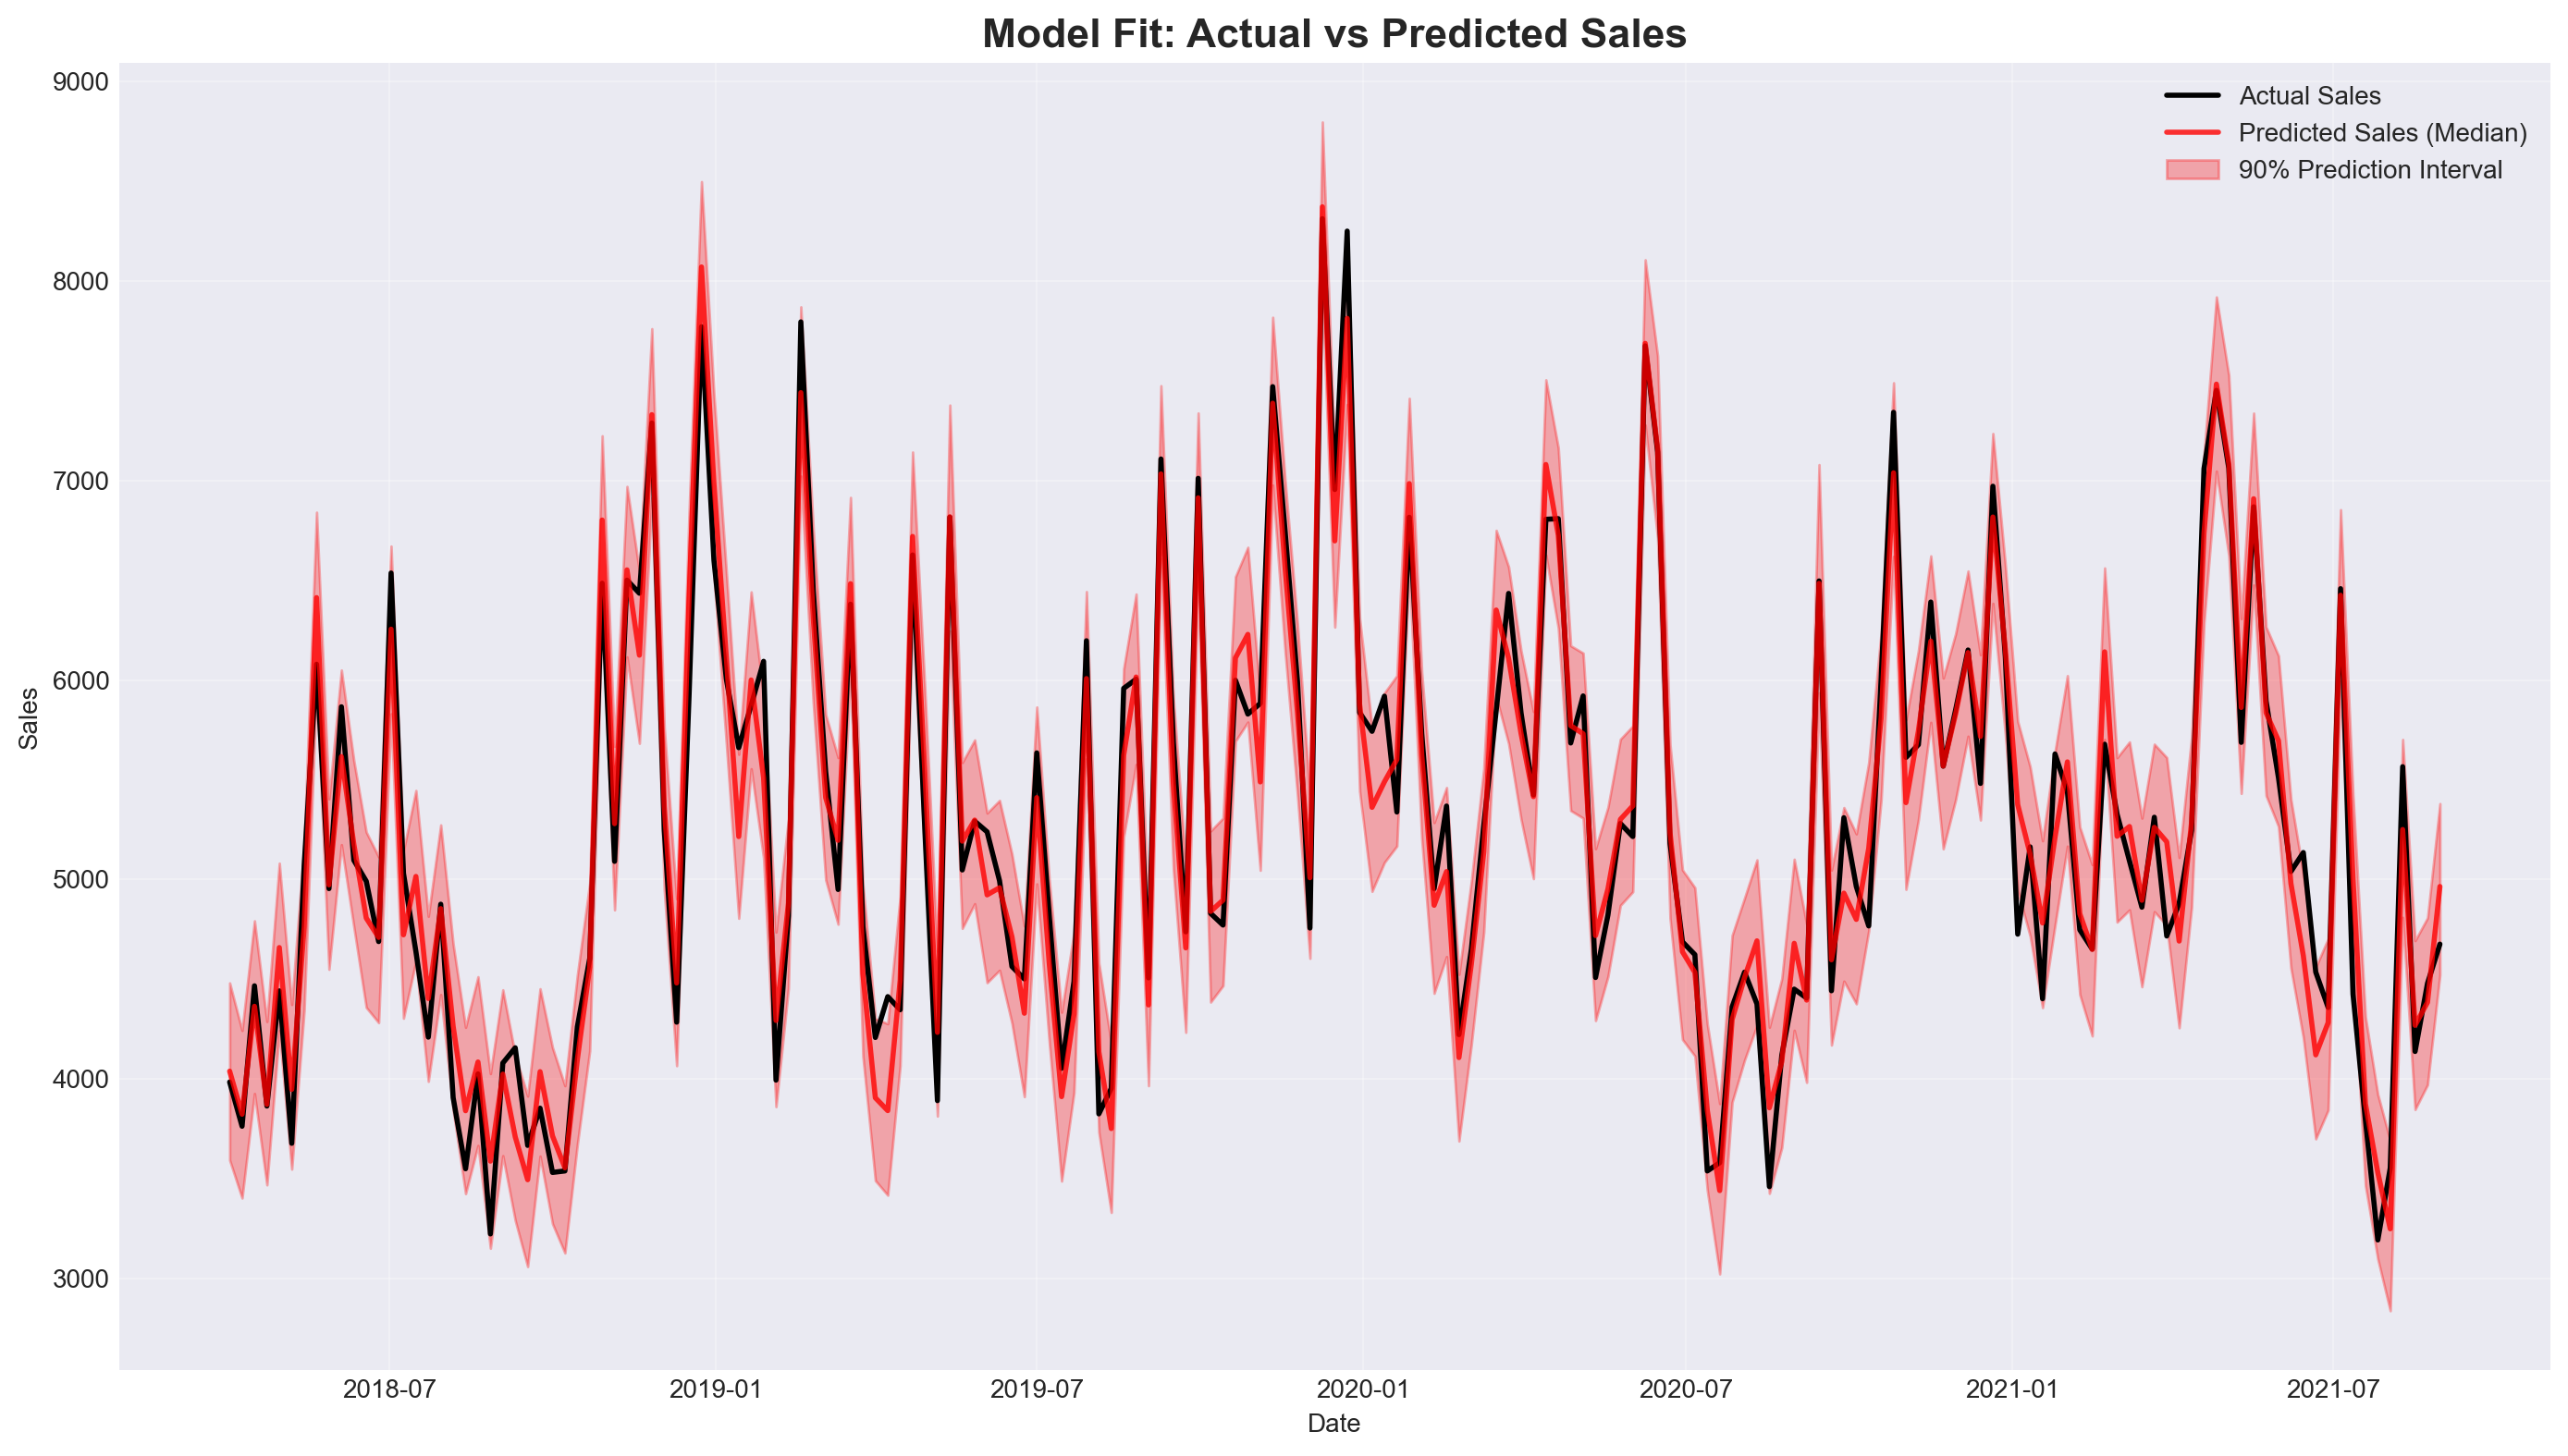

In [15]:
# Plot model fit
fig, ax = plt.subplots(figsize=(14, 8))

# Actual sales
ax.plot(data["date_week"], y, label="Actual Sales", color="black", linewidth=2)

# Predicted sales (median)
y_pred_median = posterior_preds.y.median(dim="sample")
ax.plot(
    data["date_week"],
    y_pred_median,
    label="Predicted Sales (Median)",
    color="red",
    linewidth=2,
    alpha=0.8,
)

# Prediction intervals
y_pred_5 = posterior_preds.y.quantile(0.05, dim="sample")
y_pred_95 = posterior_preds.y.quantile(0.95, dim="sample")
ax.fill_between(
    data["date_week"],
    y_pred_5,
    y_pred_95,
    alpha=0.3,
    color="red",
    label="90% Prediction Interval",
)

ax.set_title("Model Fit: Actual vs Predicted Sales", fontsize=16, fontweight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Channel Contribution Analysis

One of the most valuable outputs of MMM is understanding how much each channel contributes to overall sales.


In [17]:
# Get channel contributions
channel_contributions = mmm.compute_channel_contribution_original_scale()

print("Channel contributions shape:", channel_contributions.shape)
print("\nChannel contribution summary:")
# print(channel_contributions.mean(dim=["sample", "date"]).to_pandas())


Channel contributions shape: (2, 1000, 179, 2)

Channel contribution summary:


## Key Takeaways and Next Steps

Congratulations! You've successfully built and analyzed your first Media Mix Model. Here's what you've accomplished:

### What You've Learned:
1. **Data Preparation**: How to structure data for MMM analysis
2. **Model Building**: Creating an MMM with adstock and saturation effects
3. **Model Fitting**: Using Bayesian inference to estimate parameters
4. **Results Analysis**: Understanding channel contributions and performance

### Key Business Insights:
- Model performance: How well the model fits your sales data
- Channel effectiveness: Which channels contribute most to sales
- Time-varying effects: How marketing impact changes over time
- Uncertainty quantification: Confidence intervals around predictions

### Next Steps:
1. **Budget Optimization**: Use `mmm.allocate_budget()` to optimize spending
2. **Scenario Planning**: Model different budget scenarios
3. **Advanced Features**: Explore time-varying parameters, lift tests, and causal inference
4. **Model Validation**: Use cross-validation and holdout testing
5. **Business Application**: Integrate insights into marketing planning

### Resources for Further Learning:
- [PyMC-Marketing Documentation](https://pymc-marketing.readthedocs.io/)
- [MMM Deep Dive Notebook](mmm_example.ipynb) - More detailed analysis
- [Budget Allocation Example](mmm_budget_allocation_example.ipynb)
- [Lift Test Integration](mmm_lift_test.ipynb)

This quickstart guide focused on the core MMM workflow. The full MMM example notebook provides more advanced features like budget optimization, lift test integration, and detailed diagnostics.


In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing,pytensor

Last updated: Sun Jun 29 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.3.0

pymc_marketing: 0.14.0
pytensor      : 2.31.3

matplotlib    : 3.10.3
numpy         : 2.2.6
pymc_marketing: 0.14.0
pandas        : 2.3.0
arviz         : 0.21.0

Watermark: 2.5.0

